In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import seaborn as sns

torch.manual_seed(100)

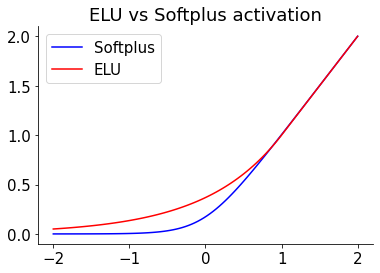

In [4]:
a = torch.linspace(-2,2,100)
plt.plot(a,F.softplus(a,beta=4),color='blue',label='Softplus')
plt.plot(a,F.elu(a-1)+1,color='red',label='ELU')
plt.title('ELU vs Softplus activation')
plt.legend()
sns.despine()
plt.show()

In [5]:
def n_choose_k(n,k):
    num_permutations = np.math.factorial(n) / (np.math.factorial(k)*np.math.factorial(n-k))
    return int(num_permutations)

def n_hot_patterns(n,length):
    all_permutations = torch.tensor(list(itertools.product([0., 1.], repeat=length)))
    pattern_hotness = torch.sum(all_permutations,axis=1)
    idx = torch.where(pattern_hotness == n)[0]
    n_hot_patterns = all_permutations[idx]
    return n_hot_patterns

print(n_choose_k(7,2))
n_hot_patterns(n=2,length=4)

21


tensor([[0., 0., 1., 1.],
        [0., 1., 0., 1.],
        [0., 1., 1., 0.],
        [1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 1., 0., 0.]])

In [38]:
class FBI_RNN(nn.Module):
    def __init__(self, input_size, Eh_size, Eo_size, Ih_size=1, Io_size=1, tau=4):
        super().__init__()
        self.in_size = input_size
        self.Eh_size = Eh_size 
        self.Ih_size = Ih_size       
        self.Eo_size = Eo_size 
        self.Io_size = Io_size 
        self.tau = tau
        
        # Hidden weights
        self.in2Eh = nn.Linear(self.in_size, self.Eh_size, bias=False)
        self.Eh2Ih = nn.Linear(self.Eh_size, self.Ih_size, bias=False)
        self.Ih2Eh = nn.Linear(self.Ih_size, self.Eh_size, bias=False)
        
        self.in2Eh.weight.data.uniform_(0, 1)
        self.Ih2Eh.weight.data.fill_(-1.)
        self.Eh2Ih.weight.data.fill_(1.)
        
        self.Ih2Eh.weight.requires_grad = False
        self.Eh2Ih.weight.requires_grad = False
        
        self.Ih_weight = nn.Parameter(torch.tensor(0.1))  

        # Output weights
        self.Eh2Eo = nn.Linear(self.Eh_size, self.Eo_size, bias=False)
        self.Eo2Io = nn.Linear(self.Eo_size, self.Io_size, bias=False)
        self.Io2Eo = nn.Linear(self.Io_size, self.Eo_size, bias=False)     
        
        self.Eh2Eo.weight.data.uniform_(0, 1)
        self.Io2Eo.weight.data.fill_(-1.)
        self.Eo2Io.weight.data.fill_(1.)

        self.Io2Eo.weight.requires_grad = False
        self.Eo2Io.weight.requires_grad = False
        
        self.Io_weight = nn.Parameter(torch.tensor(0.1))  
    
    
    def forward(self, input_pattern, Eh0, Ih0, Eh_preact, Ih_preact, Eo0, Io0, Eo_preact, Io_preact, act_sharpness=4):
        
        Eh_preact = Eh_preact + (-Eh_preact + self.in2Eh(input_pattern) + self.Ih2Eh(Ih0)*self.Ih_weight) / self.tau
        Eh = F.softplus(Eh_preact, beta=act_sharpness)
        Ih_preact = Ih_preact + (-Ih_preact + self.Eh2Ih(Eh0)) / self.tau
        Ih = F.softplus(Ih_preact, beta=act_sharpness)        
        
        Eo_preact = Eo_preact + (-Eo_preact + self.Eh2Eo(Eh) + self.Io2Eo(Io0)*self.Io_weight) / self.tau
        Eo = F.softplus(Eo_preact, beta=act_sharpness)
        Io_preact = Io_preact + (-Io_preact + self.Eo2Io(Eo0)) / self.tau
        Io = F.softplus(Io_preact, beta=act_sharpness)

        return Eh, Eh_preact, Ih, Ih_preact, Eo, Eo_preact, Io, Io_preact
    
        
    def train(self, num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, learning_rate):
        
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        num_patterns = all_patterns.shape[0]
        
        output_history = torch.zeros(self.Eo_size, num_timesteps, num_patterns, num_epochs)
        fbi_history = torch.zeros(self.Io_size, num_timesteps, num_patterns, num_epochs)
        loss_history = []
        
        for epoch in tqdm(range(num_epochs)):
            for pattern_idx in torch.randperm(num_patterns):
                
                input_pattern = all_patterns[pattern_idx]
                target  = torch.eye(self.Eo_size)[pattern_idx]
                
                Eh = torch.zeros(self.Eh_size)
                Ih = torch.zeros(self.Ih_size)
                Eh_preact = torch.zeros(self.Eh_size)
                Ih_preact = torch.zeros(self.Ih_size)
                
                Eo = torch.zeros(self.Eo_size)
                Io = torch.zeros(self.Io_size)
                Eo_preact = torch.zeros(self.Eo_size)
                Io_preact = torch.zeros(self.Io_size)
                
                loss = 0
                for t in range(num_timesteps): #iterate through all timepoints of the RNN                    
                    if t >= (eval_step - num_BPTT_steps) and t <= eval_step: #truncate BPTT to only evaluate n steps from the end
                        track_grad = True
                    else:
                        track_grad = False
                        
                    with torch.set_grad_enabled(track_grad):
                        Eh, Eh_preact, Ih, Ih_preact, Eo, Eo_preact, Io, Io_preact = self.forward(input_pattern, Eh, Ih, Eh_preact, Ih_preact, Eo, Io, Eo_preact, Io_preact)
                        
                    
                    output_history[:,t,pattern_idx,epoch] = Eo.detach()
                    fbi_history[:,t,pattern_idx,epoch] = Io.detach()

                    if t == eval_step:
                        loss += criterion(Eo, target)
                                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                loss_history.append(loss.detach())
                
                self.in2Eh.weight.data = self.in2Eh.weight.data.clamp(0,100)
                self.Ih2Eh.weight.data = self.Ih2Eh.weight.data.clamp(-100,0)
                self.Eh2Ih.weight.data = self.Eh2Ih.weight.data.clamp(0,100)
                self.Ih_weight.data = self.Ih_weight.data.clamp(0,100)
                
                self.Eh2Eo.weight.data = self.Eh2Eo.weight.data.clamp(0,100)
                self.Io2Eo.weight.data = self.Io2Eo.weight.data.clamp(-100,0)
                self.Eo2Io.weight.data = self.Eo2Io.weight.data.clamp(0,100)                
                self.Io_weight.data = self.Io_weight.data.clamp(0,100)
                
        print((2+epoch/100)**2)
            
        return output_history, fbi_history, torch.tensor(loss_history)

100%|██████████| 1000/1000 [01:02<00:00, 15.95it/s]


143.7601


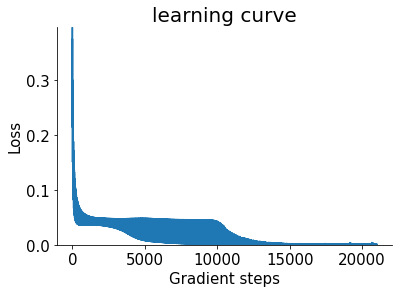

In [39]:
# Initialize RNN
input_size = 21
hidden_size = 7
output_size = 21

model = FBI_RNN(input_size, hidden_size, output_size)


# Train network
num_epochs = 1000
num_timesteps = 20
eval_step = 19
num_BPTT_steps = 0 #how many steps in the past to backpropagate the error
lr = 0.001

all_patterns = n_hot_patterns(n=1,length=input_size)

output_history, fbi_history, loss_history = model.train(num_epochs, num_timesteps, eval_step, num_BPTT_steps, all_patterns, lr)

plt.plot(loss_history)
plt.xlabel('Gradient steps')
plt.ylabel('Loss')
plt.ylim([0,torch.max(loss_history)])
plt.title('learning curve',fontsize=20)

sns.despine()
plt.show()

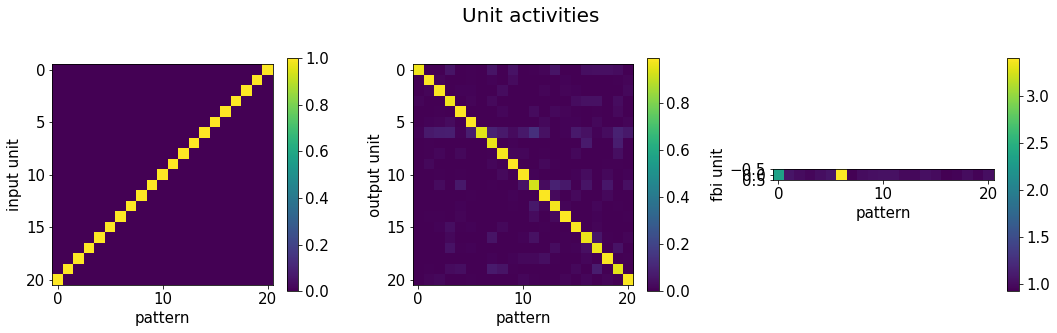

In [40]:
epoch = -1
time = eval_step

fig, ax = plt.subplots(1,3,figsize=(15,4.5))
axis = 0
im = ax[axis].imshow(all_patterns.T,aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('input unit')

axis = 1
im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('output unit')

axis = 2
im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('pattern')
ax[axis].set_ylabel('fbi unit')

plt.suptitle("Unit activities",fontsize=20)
plt.tight_layout()
plt.show()

In [41]:
import ipywidgets as widgets

def plot_activity(time):
    epoch = -1

    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    plt.suptitle(f"Unit activities, epoch = {epoch}",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity, time=(0,num_timesteps-1,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=9, description='time', max=19), Output()), _dom_classes=('widget-interac…

In [42]:
import ipywidgets as widgets

def plot_activity(epoch):
    epoch = epoch*10
    time = -1

    fig, ax = plt.subplots(1,3,figsize=(15,4.5))
    axis = 0
    im = ax[axis].imshow(all_patterns.T,aspect='equal')
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('input unit')

    axis = 1
    im = ax[axis].imshow(output_history[:,time,:,epoch],aspect='equal',vmax=1,vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('output unit')

    axis = 2
    im = ax[axis].imshow(fbi_history[:,time,:,epoch],aspect='equal',vmax=1.8,vmin=0)
    plt.colorbar(im, ax=ax[axis])
    ax[axis].set_xlabel('pattern')
    ax[axis].set_ylabel('fbi unit')

    plt.suptitle("Unit activities",fontsize=20)
    plt.tight_layout()
    plt.show()

widgets.interact(plot_activity, epoch=(0,99,1));
# widgets.interact(plot_activity, epoch=widgets.Play(min=1,max=80));

interactive(children=(IntSlider(value=49, description='epoch', max=99), Output()), _dom_classes=('widget-inter…

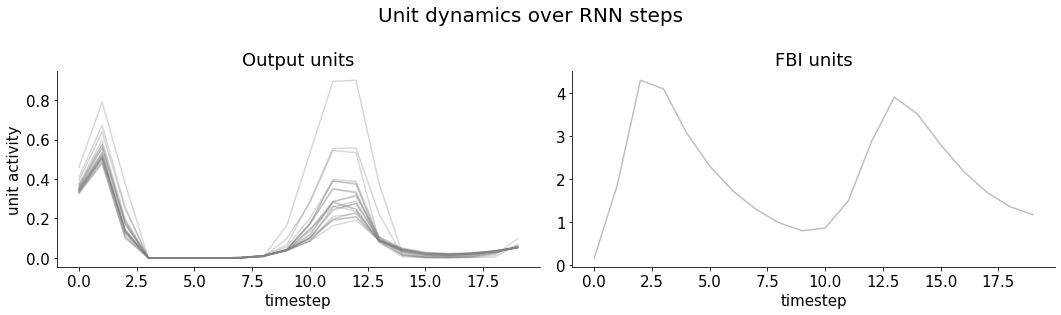

In [43]:
fix, ax = plt.subplots(1,2,figsize=(15,4.5))
for i,_ in enumerate(all_patterns):
    ax[0].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
ax[0].set_xlabel('timestep')
ax[0].set_ylabel('unit activity')
ax[0].set_title('Output units')

for i in range(model.Io_size):
    ax[1].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
ax[1].set_xlabel('timestep')
ax[1].set_title('FBI units')  
    
plt.suptitle('Unit dynamics over RNN steps',fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()

In [44]:
import ipywidgets as widgets

def plot_oscillation(epoch):
    
    epoch = epoch*10
    
    fix, ax = plt.subplots(1,2,figsize=(15,4.5))
    for i,_ in enumerate(all_patterns):
        ax[0].plot(torch.mean(output_history[i,:,:,epoch],axis=1),color='gray',alpha=0.3)
    ax[0].set_xlabel('timestep')
    ax[0].set_ylabel('unit activity')
    ax[0].set_title('Output units')
    ax[0].set_ylim([0,1.4])

    for i in range(model.Io_size):
        ax[1].plot(torch.mean(fbi_history[i,:,:,epoch],axis=1),color='gray',alpha=0.5)
    ax[1].set_xlabel('timestep')
    ax[1].set_title('FBI units')  
    ax[1].set_ylim([0,14])

    plt.suptitle('Unit dynamics over RNN steps',fontsize=20)

    sns.despine()
    plt.tight_layout()
    plt.show()

widgets.interact(plot_oscillation, epoch=(0,99,1));
# widgets.interact(plot_oscillation, epoch=widgets.Play(min=1,max=50));

interactive(children=(IntSlider(value=49, description='epoch', max=99), Output()), _dom_classes=('widget-inter…

Weights: 
 I_hidden = -0.0 
 I_out = -2.1467716693878174


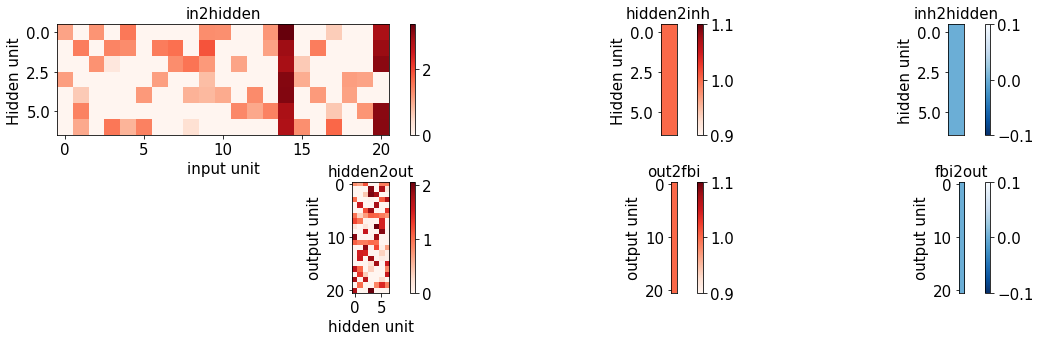

In [50]:
fig, ax = plt.subplots(2,3,figsize=(15,5))

# Hidden weights
axis = 0,0
im = ax[axis].imshow(model.in2Eh.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('input unit')
ax[axis].set_ylabel('Hidden unit')
ax[axis].set_title('in2hidden',fontsize=15)

axis = 0,1
im = ax[axis].imshow(model.Eh2Ih.weight.data.T,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('Hidden unit')
ax[axis].set_xlabel('Ih unit')
ax[axis].set_title('hidden2inh',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

axis = 0,2
im = ax[axis].imshow(model.Ih2Eh.weight.data*model.Ih_weight.detach(),
                     aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('Ih unit')
ax[axis].set_ylabel('hidden unit')
ax[axis].set_title('inh2hidden',fontsize=15)
ax[axis].get_xaxis().set_visible(False)


# Output weights
axis = 1,0
im = ax[axis].imshow(model.Eh2Eo.weight.data,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('hidden unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('hidden2out',fontsize=15)

axis = 1,1
im = ax[axis].imshow(model.Eo2Io.weight.data.T,aspect='equal',cmap='Reds')
plt.colorbar(im, ax=ax[axis])
ax[axis].set_ylabel('output unit')
ax[axis].set_xlabel('Io unit')
ax[axis].set_title('out2fbi',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

axis = 1,2
im = ax[axis].imshow(model.Io2Eo.weight.data*model.Ih_weight.detach(),
                     aspect='equal',cmap='Blues_r',vmax=0)
plt.colorbar(im, ax=ax[axis])
ax[axis].set_xlabel('Io unit')
ax[axis].set_ylabel('output unit')
ax[axis].set_title('fbi2out',fontsize=15)
ax[axis].get_xaxis().set_visible(False)

print(f"Weights: \n I_hidden = -{model.Ih_weight.detach()} \n I_out = -{model.Io_weight.detach()}")

plt.tight_layout()
plt.show()

# TODO:

Plot hidden activities, tune hyperparams to avoid oscillation
Same but without dale's law